# Image Deblurring

## Import Necessary Libraries

In [1]:
import os
from pathlib import Path
import cv2
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

## Load all images with different extensions (.jpg, .jpeg, .png)

In [2]:
def get_image_files(directory, extensions=[".png", ".jpg", ".jpeg"]):
    files = []
    for ext in extensions:
        files.extend(directory.glob(f"*{ext}"))
    return sorted(files)

In [3]:
def load_data(parent_dir, dataset_names=None, splits=["train", "test", "validation"],
              blur_folder_names=["blur"], sharp_folder_names=["sharp"]):
    data = []
    parent_path = Path(parent_dir)
    
    if dataset_names is None:
        dataset_names = [d.name for d in parent_path.iterdir() if d.is_dir()]
    
    for ds in dataset_names:
        ds_path = parent_path / ds
        for split in splits:
            split_dirs = [d for d in ds_path.iterdir() if d.is_dir() and d.name.lower() == split.lower()]
            if not split_dirs:
                continue
            split_path = split_dirs[0]
            
            # Variant 1: Split folder directly contains the required folders.
            sharp_candidates = [d for d in split_path.iterdir() 
                                if d.is_dir() and d.name.lower() in [name.lower() for name in sharp_folder_names]]
            if sharp_candidates:
                sharp_dir = sharp_candidates[0]
                blur_candidates = [d for d in split_path.iterdir() 
                                   if d.is_dir() and d.name.lower() in [name.lower() for name in blur_folder_names]]
                if not blur_candidates:
                    print(f"Dataset '{ds}', split '{split}': No blur folder found. Skipping.")
                    continue
                blur_dir = blur_candidates[0]
                blurred_images = get_image_files(blur_dir)
                sharp_images = get_image_files(sharp_dir)
                n = min(len(blurred_images), len(sharp_images))
                if n == 0:
                    print(f"Dataset '{ds}', split '{split}': No images found. Skipping.")
                    continue
                if len(blurred_images) != len(sharp_images):
                    print(f"Dataset '{ds}', split '{split}': Count mismatch (blur: {len(blurred_images)}, sharp: {len(sharp_images)}). Using first {n} images.")
                for b_img, s_img in zip(blurred_images[:n], sharp_images[:n]):
                    data.append((str(b_img), str(s_img), ds, split))
            else:
                # Variant 2: Split folder contains scene subfolders.
                for scene_folder in split_path.iterdir():
                    if not scene_folder.is_dir():
                        continue
                    scene_sharp_candidates = [d for d in scene_folder.iterdir() 
                                              if d.is_dir() and d.name.lower() in [name.lower() for name in sharp_folder_names]]
                    if not scene_sharp_candidates:
                        print(f"Skipping scene '{scene_folder.name}' in dataset '{ds}', split '{split}': no sharp folder found.")
                        continue
                    sharp_dir = scene_sharp_candidates[0]
                    sharp_images = get_image_files(sharp_dir)
                    scene_blur_candidates = [d for d in scene_folder.iterdir() 
                                             if d.is_dir() and d.name.lower() in [name.lower() for name in blur_folder_names]]
                    if not scene_blur_candidates:
                        print(f"Skipping scene '{scene_folder.name}' in dataset '{ds}', split '{split}': no blur folder found.")
                        continue
                    for blur_dir in scene_blur_candidates:
                        blurred_images = get_image_files(blur_dir)
                        n = min(len(blurred_images), len(sharp_images))
                        if n == 0:
                            continue
                        if len(blurred_images) != len(sharp_images):
                            print(f"Dataset '{ds}', scene '{scene_folder.name}', split '{split}', folder '{blur_dir.name}': Count mismatch (blur: {len(blurred_images)}, sharp: {len(sharp_images)}). Using first {n} images.")
                        for b_img, s_img in zip(blurred_images[:n], sharp_images[:n]):
                            data.append((str(b_img), str(s_img), ds, split))
    return data

## Pre-processing and Perceptual Loss

In [4]:
class DeblurringDataset(Dataset):
    def __init__(self, data, img_size=(640, 360), normalize=True, transforms=None):
        self.data = data
        self.img_size = img_size
        self.normalize = normalize
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        blurred_path, sharp_path, _, _ = self.data[idx]
        blurred = cv2.imread(blurred_path)
        sharp = cv2.imread(sharp_path)
        if blurred is None or sharp is None:
            raise ValueError(f"Error loading images: {blurred_path} or {sharp_path}")
        blurred = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)
        sharp = cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB)
        blurred = cv2.resize(blurred, self.img_size)
        sharp = cv2.resize(sharp, self.img_size)
        if self.normalize:
            blurred = blurred / 255.0
            sharp = sharp / 255.0
        if self.transforms:
            blurred = self.transforms(blurred)
            sharp = self.transforms(sharp)
        else:
            blurred = torch.from_numpy(np.transpose(blurred, (2, 0, 1))).float()
            sharp = torch.from_numpy(np.transpose(sharp, (2, 0, 1))).float()
        return blurred, sharp

# ------------------------------
# Perceptual Loss (using VGG16 features)
# ------------------------------
class PerceptualLoss(nn.Module):
    def __init__(self, layer_index=16):
        super(PerceptualLoss, self).__init__()
        # Load VGG16 pretrained on ImageNet and extract features up to a given layer index.
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:layer_index]
        self.feature_extractor = nn.Sequential(*list(vgg.children())).eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, pred, target):
        # Resize to VGG input size if needed (e.g., 224x224)
        if pred.shape[2:] != (224, 224):
            pred = F.interpolate(pred, size=(224, 224), mode='bicubic', align_corners=False)
        if target.shape[2:] != (224, 224):
            target = F.interpolate(target, size=(224, 224), mode='bicubic', align_corners=False)
        pred_features = self.feature_extractor(pred)
        target_features = self.feature_extractor(target)
        return F.l1_loss(pred_features, target_features)

## Feature Refinement and Model Architecture

In [5]:
# Refinement Block (a simple residual block for feature refinement)
class RefinementBlock(nn.Module):
    def __init__(self, channels):
        super(RefinementBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.block(x)
        return self.relu(x + out)

class CNNEncoder(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super(CNNEncoder, self).__init__()
        self.layers = nn.ModuleList()
        for feature in features:
            self.layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, feature, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True)
                )
            )
            in_channels = feature
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        features = []
        for layer in self.layers:
            x = layer(x)
            features.append(x)
            x = self.pool(x)
        return features, x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        res = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = res + attn_out
        res = x
        x = self.norm2(x)
        x = res + self.mlp(x)
        return x

class TransformerDecoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerDecoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x, memory):
        res = x
        x = self.norm1(x)
        attn_out, _ = self.cross_attn(x, memory, memory)
        x = res + attn_out
        res = x
        x = self.norm2(x)
        x = res + self.mlp(x)
        return x

class HybridDeblurNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_dim=64, num_heads=4, num_transformer_layers=2):
        super(HybridDeblurNet, self).__init__()
        self.encoder = CNNEncoder(in_channels=in_channels, features=[base_dim, base_dim*2, base_dim*4, base_dim*8])
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(dim=base_dim*8, num_heads=num_heads) for _ in range(num_transformer_layers)]
        )
        self.up_conv = nn.ConvTranspose2d(base_dim*8, base_dim*4, kernel_size=2, stride=2)
        self.skip_conv = nn.Conv2d(base_dim*8, base_dim*4, kernel_size=1)
        self.transformer_decoder = TransformerDecoderBlock(dim=base_dim*4, num_heads=num_heads)
        # Add a refinement block after the transformer decoder to further process features.
        self.refinement = RefinementBlock(base_dim*4)
        self.decoder_conv = nn.Sequential(
            nn.Conv2d(base_dim*4, base_dim*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_dim*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_dim*2, base_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_dim, out_channels, kernel_size=3, stride=1, padding=1)
        )
    
    def forward(self, x):
        original_size = x.shape[2:]
        enc_features, deep_feat = self.encoder(x)
        B, C, H, W = deep_feat.shape
        # --- Reduce sequence length via pooling for memory savings ---
        pooled_feat = F.adaptive_avg_pool2d(deep_feat, (H//2, W//2))
        B, C, H_p, W_p = pooled_feat.shape
        tokens = pooled_feat.flatten(2).transpose(1,2)  # (B, H_p*W_p, C)
        tokens = self.transformer_encoder(tokens)
        pooled_feat = tokens.transpose(1,2).view(B, C, H_p, W_p)
        deep_feat = F.interpolate(pooled_feat, size=(H, W), mode='bicubic', align_corners=False)
        # ----------------------------------------------------------
        x_dec = self.up_conv(deep_feat)  # (B, base_dim*4, H/8, W/8)
        skip = enc_features[3]           # (B, base_dim*8, H/8, W/8)
        skip = self.skip_conv(skip)        # (B, base_dim*4, H/8, W/8)
        if x_dec.shape[2:] != skip.shape[2:]:
            x_dec = F.interpolate(x_dec, size=skip.shape[2:], mode='bicubic', align_corners=False)
        x_dec = x_dec + skip
        B, C, H, W = x_dec.shape
        dec_tokens = x_dec.flatten(2).transpose(1,2)
        mem_tokens = skip.flatten(2).transpose(1,2)
        dec_tokens = self.transformer_decoder(dec_tokens, memory=mem_tokens)
        x_dec = dec_tokens.transpose(1,2).view(B, C, H, W)
        # Refinement block for further feature processing.
        x_dec = self.refinement(x_dec)
        x_out = self.decoder_conv(x_dec)
        x_out = F.interpolate(x_out, size=original_size, mode='bicubic', align_corners=False)
        x_out = torch.sigmoid(x_out)
        return x_out

## Model Training

In [6]:
def train_deblurring(generator, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), patience=7, lambda_perc=0.5):
    """
    Trains the generator using a combined loss:
      total_loss = L1_loss + lambda_perc * perceptual_loss.
    
    Uses mixed precision training, a learning rate scheduler (ReduceLROnPlateau),
    and early stopping based on validation loss.
    
    Args:
        generator: The deblurring model.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: L1 loss function.
        optimizer: Optimizer.
        num_epochs: Total epochs to run (set to 20 here).
        device: Device to run training on.
        patience: Early stopping patience.
        lambda_perc: Weight for the perceptual loss.
        
    Returns:
        loss_history: List of training losses.
    """
    # Initialize perceptual loss.
    perc_loss_fn = PerceptualLoss().to(device)
    
    generator.to(device)
    best_val_loss = float('inf')
    epochs_no_improve = 0
    loss_history = []
    scaler = torch.amp.GradScaler()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=7, verbose=True)
    
    for epoch in range(num_epochs):
        generator.train()
        total_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")
        for blurred, sharp in pbar:
            blurred = blurred.to(device)
            sharp = sharp.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast("cuda"):
                output = generator(blurred)
                loss_l1 = criterion(output, sharp)
                loss_perc = perc_loss_fn(output, sharp)
                loss = loss_l1 + lambda_perc * loss_perc
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
            pbar.set_postfix({'Loss': loss.item()})
        avg_train_loss = total_loss / len(train_loader)
        loss_history.append(avg_train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Training Loss: {avg_train_loss:.4f}")
        
        generator.eval()
        val_loss = 0.0
        with torch.no_grad():
            for blurred, sharp in val_loader:
                blurred = blurred.to(device)
                sharp = sharp.to(device)
                with torch.amp.autocast("cuda"):
                    output = generator(blurred)
                    loss_val_l1 = criterion(output, sharp)
                    loss_val_perc = perc_loss_fn(output, sharp)
                    loss_val = loss_val_l1 + lambda_perc * loss_val_perc
                val_loss += loss_val.item()
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Validation Loss: {avg_val_loss:.4f}")
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break
        
        torch.save(generator.state_dict(), f"hybrid_deblur_epoch_{epoch+1}.pth")
    
    # Plot the training loss curve once after training.
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    plt.show()
    
    return loss_history

## Model Evaluation

In [7]:
def evaluate_model(generator, test_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    generator.eval()
    psnr_scores = []
    ssim_scores = []
    with torch.no_grad():
        for blurred, sharp in tqdm(test_loader, desc="Evaluating"):
            blurred = blurred.to(device)
            sharp = sharp.to(device)
            with torch.amp.autocast("cuda"):
                output = generator(blurred)
            output = F.interpolate(output, size=sharp.shape[2:], mode='bicubic', align_corners=False)
            output_np = output.cpu().numpy()
            sharp_np = sharp.cpu().numpy()
            for i in range(output_np.shape[0]):
                out_img = output_np[i].transpose(1,2,0)
                sharp_img = sharp_np[i].transpose(1,2,0)
                out_img = np.clip(out_img, 0, 1)
                sharp_img = np.clip(sharp_img, 0, 1)
                psnr_scores.append(psnr(sharp_img, out_img, data_range=1.0))
                ssim_scores.append(ssim(sharp_img, out_img, data_range=1.0, channel_axis=-1))
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)
    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    return avg_psnr, avg_ssim

## Visualize Samples

In [8]:
def visualize_multiple_samples(generator, test_loader, device, num_samples=3):
    generator.eval()
    samples_shown = 0
    plt.figure(figsize=(15, num_samples * 5))
    with torch.no_grad():
        for blurred, sharp in test_loader:
            blurred = blurred.to(device)
            sharp = sharp.to(device)
            with torch.amp.autocast("cuda"):
                deblurred = generator(blurred)
            blurred_np = blurred[0].permute(1,2,0).cpu().numpy()
            deblurred_np = deblurred[0].permute(1,2,0).cpu().numpy()
            sharp_np = sharp[0].permute(1,2,0).cpu().numpy()
            blurred_np = np.clip(blurred_np, 0, 1)
            deblurred_np = np.clip(deblurred_np, 0, 1)
            sharp_np = np.clip(sharp_np, 0, 1)
            
            plt.subplot(num_samples, 3, samples_shown*3 + 1)
            plt.title("Blurred")
            plt.imshow(blurred_np)
            plt.axis("off")
            
            plt.subplot(num_samples, 3, samples_shown*3 + 2)
            plt.title("Deblurred")
            plt.imshow(deblurred_np)
            plt.axis("off")
            
            plt.subplot(num_samples, 3, samples_shown*3 + 3)
            plt.title("Sharp")
            plt.imshow(sharp_np)
            plt.axis("off")
            
            samples_shown += 1
            if samples_shown >= num_samples:
                break
    plt.tight_layout()
    plt.show()

## Main Execution Block

Loaded 213633 train pairs and 7628 test pairs from datasets: {'RealBlur_J', 'Helen', 'TextOCR', 'Gopro', 'Wider-Face', 'HIDE', 'CelebA', 'RealBlur_R'}
Using 21363 training pairs for faster experiments.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 214MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/20 Training: 100%|██████████| 5341/5341 [08:01<00:00, 11.09it/s, Loss=0.296]

Epoch [1/20] Average Training Loss: 0.2826


Epoch [1/20] Average Validation Loss: 0.2967


Epoch 2/20 Training: 100%|██████████| 5341/5341 [07:56<00:00, 11.20it/s, Loss=0.226]

Epoch [2/20] Average Training Loss: 0.2610


Epoch [2/20] Average Validation Loss: 0.2836


Epoch 3/20 Training: 100%|██████████| 5341/5341 [07:56<00:00, 11.21it/s, Loss=0.248]

Epoch [3/20] Average Training Loss: 0.2536


Epoch [3/20] Average Validation Loss: 0.2877


Epoch 4/20 Training: 100%|██████████| 5341/5341 [07:56<00:00, 11.21it/s, Loss=0.284]

Epoch [4/20] Average Training Loss: 0.2492


Epoch [4/20] Average Validation Loss: 0.2806


Epoch 5/20 Training: 100%|██████████| 5341/5341 [07:56<00:00, 11.21it/s, Loss=0.225]

Epoch [5/20] Average Training Loss: 0.2463


Epoch [5/20] Average Validation Loss: 0.2756


Epoch 6/20 Training: 100%|██████████| 5341/5341 [07:59<00:00, 11.15it/s, Loss=0.212]

Epoch [6/20] Average Training Loss: 0.2441


Epoch [6/20] Average Validation Loss: 0.2758


Epoch 7/20 Training: 100%|██████████| 5341/5341 [07:59<00:00, 11.14it/s, Loss=0.25] 

Epoch [7/20] Average Training Loss: 0.2425


Epoch [7/20] Average Validation Loss: 0.2742


Epoch 8/20 Training: 100%|██████████| 5341/5341 [07:57<00:00, 11.18it/s, Loss=0.3]  

Epoch [8/20] Average Training Loss: 0.2412


Epoch [8/20] Average Validation Loss: 0.2727


Epoch 9/20 Training: 100%|██████████| 5341/5341 [07:56<00:00, 11.20it/s, Loss=0.214]

Epoch [9/20] Average Training Loss: 0.2401


Epoch [9/20] Average Validation Loss: 0.2740


Epoch 10/20 Training: 100%|██████████| 5341/5341 [07:56<00:00, 11.21it/s, Loss=0.211]

Epoch [10/20] Average Training Loss: 0.2391


Epoch [10/20] Average Validation Loss: 0.2723


Epoch 11/20 Training: 100%|██████████| 5341/5341 [07:56<00:00, 11.20it/s, Loss=0.231]

Epoch [11/20] Average Training Loss: 0.2383


Epoch [11/20] Average Validation Loss: 0.2723


Epoch 12/20 Training: 100%|██████████| 5341/5341 [07:56<00:00, 11.21it/s, Loss=0.256]

Epoch [12/20] Average Training Loss: 0.2376


Epoch [12/20] Average Validation Loss: 0.2707


Epoch 13/20 Training: 100%|██████████| 5341/5341 [07:56<00:00, 11.20it/s, Loss=0.273]

Epoch [13/20] Average Training Loss: 0.2371


Epoch [13/20] Average Validation Loss: 0.2709


Epoch 14/20 Training: 100%|██████████| 5341/5341 [07:56<00:00, 11.21it/s, Loss=0.3]  

Epoch [14/20] Average Training Loss: 0.2364


Epoch [14/20] Average Validation Loss: 0.2705


Epoch 15/20 Training: 100%|██████████| 5341/5341 [07:55<00:00, 11.24it/s, Loss=0.237]


Epoch [15/20] Average Training Loss: 0.2359
Epoch [15/20] Average Validation Loss: 0.2716


Epoch 16/20 Training: 100%|██████████| 5341/5341 [07:55<00:00, 11.24it/s, Loss=0.236]

Epoch [16/20] Average Training Loss: 0.2354


Epoch [16/20] Average Validation Loss: 0.2677


Epoch 17/20 Training: 100%|██████████| 5341/5341 [07:55<00:00, 11.23it/s, Loss=0.214]

Epoch [17/20] Average Training Loss: 0.2350


Epoch [17/20] Average Validation Loss: 0.2688


Epoch 18/20 Training: 100%|██████████| 5341/5341 [07:55<00:00, 11.23it/s, Loss=0.184]

Epoch [18/20] Average Training Loss: 0.2345


Epoch [18/20] Average Validation Loss: 0.2682


Epoch 19/20 Training: 100%|██████████| 5341/5341 [07:55<00:00, 11.23it/s, Loss=0.204]

Epoch [19/20] Average Training Loss: 0.2342


Epoch [19/20] Average Validation Loss: 0.2709


Epoch 20/20 Training: 100%|██████████| 5341/5341 [07:55<00:00, 11.23it/s, Loss=0.217]

Epoch [20/20] Average Training Loss: 0.2338


Epoch [20/20] Average Validation Loss: 0.2696


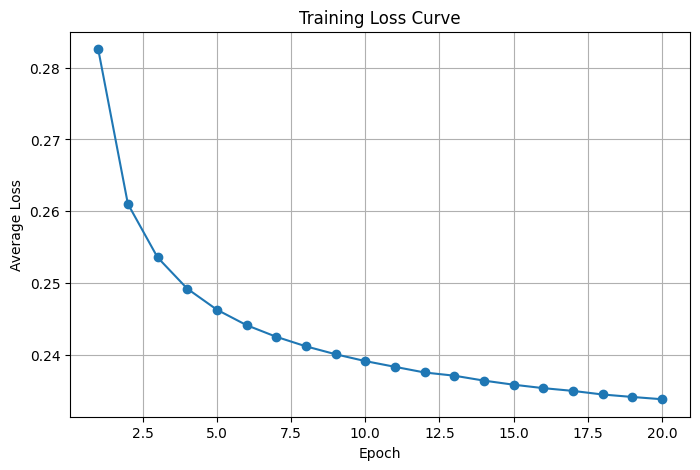

Evaluating: 100%|██████████| 7628/7628 [44:17<00:00,  2.87it/s]

Average PSNR: 23.4706
Average SSIM: 0.6929


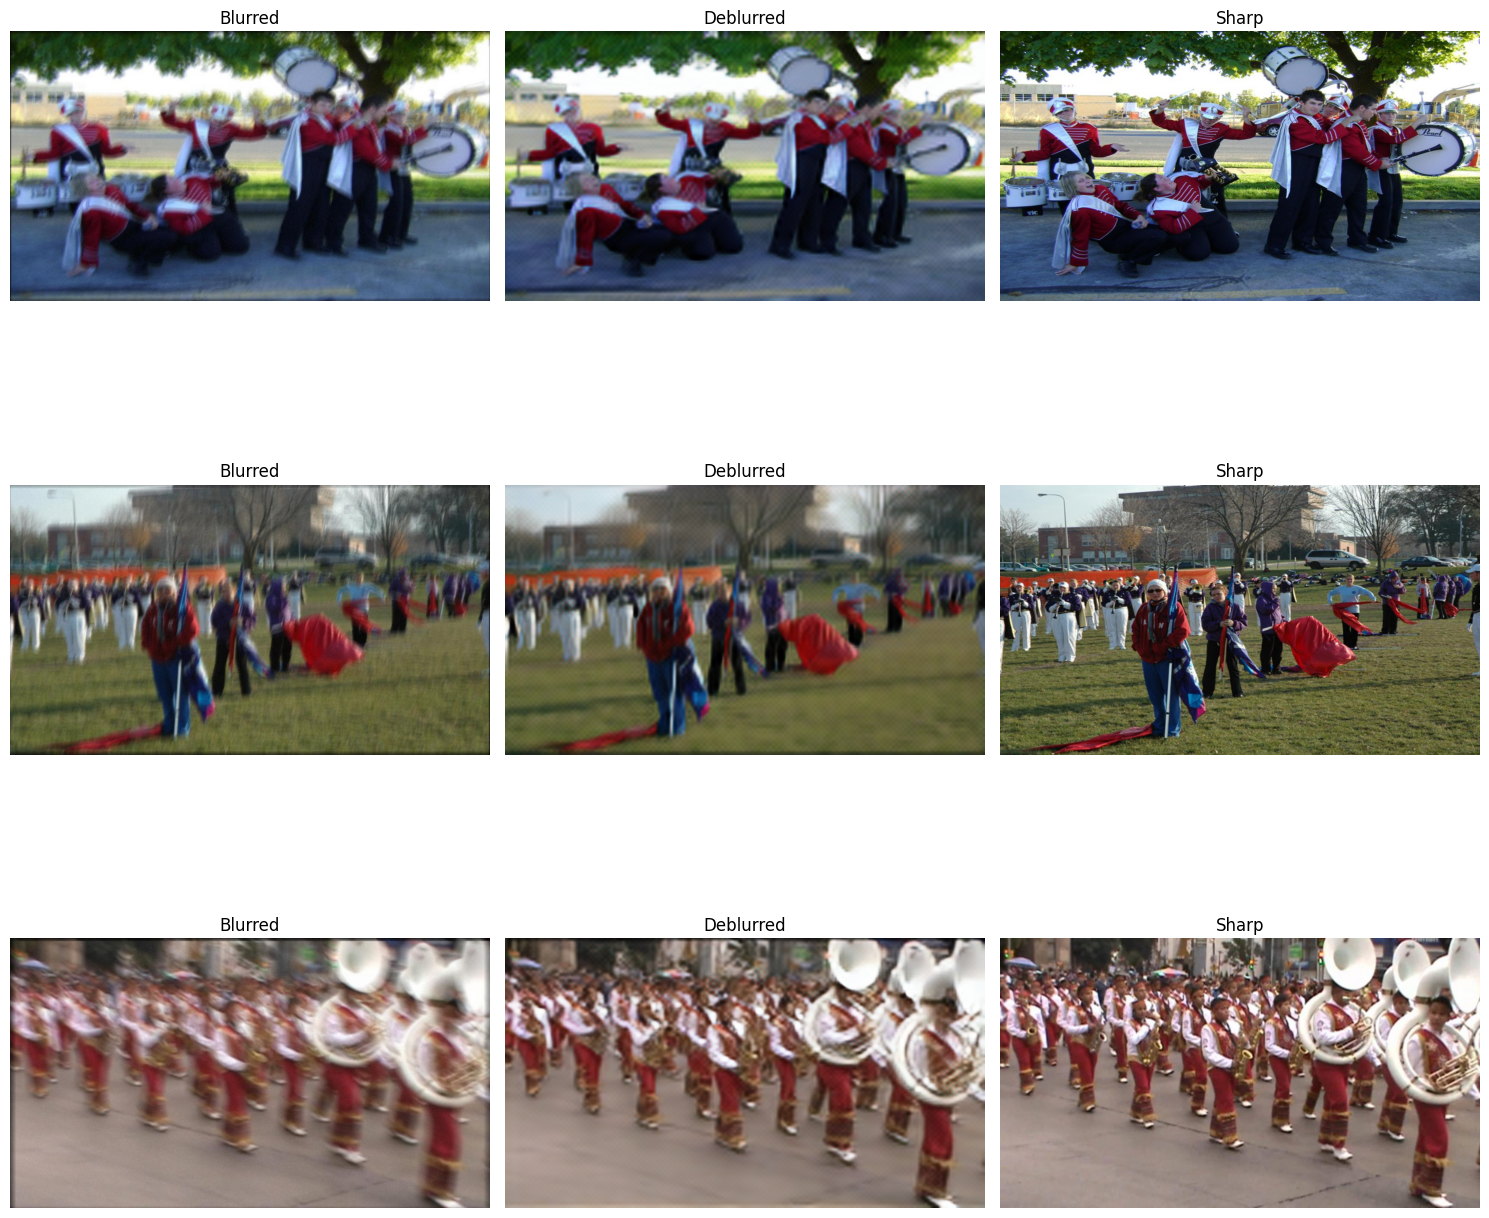

In [9]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load data from the curated dataset on Kaggle.
    parent_dir = "/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur"  
    all_data = load_data(parent_dir, dataset_names=None, splits=["train", "test"],
                         blur_folder_names=["blur"], sharp_folder_names=["sharp"])
    train_data = [d for d in all_data if d[3].lower() == "train"]
    test_data = [d for d in all_data if d[3].lower() == "test"]
    print(f"Loaded {len(train_data)} train pairs and {len(test_data)} test pairs from datasets: {set([item[2] for item in all_data])}")
    
    # Optionally subsample training data for faster experiments.
    random.seed(42)
    subset_size = int(0.1 * len(train_data))
    train_data_subset = random.sample(train_data, subset_size)
    print(f"Using {len(train_data_subset)} training pairs for faster experiments.")
    
    # Use lower resolution for training.
    train_dataset = DeblurringDataset(train_data_subset, img_size=(320, 180))
    # For evaluation, use higher resolution.
    test_dataset = DeblurringDataset(test_data, img_size=(1280, 720))
    
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
    
    # For validation, use a subset of the test set.
    val_loader = test_loader
    
    # Initialize the HybridDeblurNet generator.
    generator = HybridDeblurNet(in_channels=3, out_channels=3, base_dim=64, num_heads=4, num_transformer_layers=2)
    
    # Train the model using combined L1 and perceptual loss.
    criterion = nn.L1Loss()
    optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    num_epochs = 20  # Increased epochs to 20.
    train_deblurring(generator, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device, patience=7, lambda_perc=0.5)
    
    # Evaluate the model.
    evaluate_model(generator, test_loader, device=device)
    
    # Visualize a single sample.
    generator.eval()
    # Visualize multiple samples.
    visualize_multiple_samples(generator, test_loader, device=device, num_samples=3)

In [15]:
import os
import matplotlib.pyplot as plt

def save_samples_separate(generator, test_loader, device, num_samples=100, output_dir="sample_outputs"):
    """
    Saves sample images from the test set into three separate folders:
      - 'blurred' for the input blurred images,
      - 'deblurred' for the model's output,
      - 'sharp' for the ground truth.
    
    Args:
        generator: Your deblurring model.
        test_loader: DataLoader for test data.
        device: The device on which the model runs (e.g., torch.device("cuda")).
        num_samples: The number of samples to save.
        output_dir: The parent folder where the three subfolders will be created.
    """
    # Create output directories for each image type.
    blurred_dir = os.path.join(output_dir, "blurred")
    deblurred_dir = os.path.join(output_dir, "deblurred")
    sharp_dir = os.path.join(output_dir, "sharp")
    os.makedirs(blurred_dir, exist_ok=True)
    os.makedirs(deblurred_dir, exist_ok=True)
    os.makedirs(sharp_dir, exist_ok=True)
    
    generator.eval()
    count = 0
    with torch.no_grad():
        for blurred, sharp in test_loader:
            if count >= num_samples:
                break
            blurred = blurred.to(device)
            sharp = sharp.to(device)
            with torch.amp.autocast("cuda"):
                deblurred = generator(blurred)
            
            # Assuming batch_size=1; extract the first sample.
            blurred_img = blurred[0].permute(1, 2, 0).cpu().numpy()
            deblurred_img = deblurred[0].permute(1, 2, 0).cpu().numpy()
            sharp_img = sharp[0].permute(1, 2, 0).cpu().numpy()
            
            # Clip images to the [0, 1] range.
            blurred_img = np.clip(blurred_img, 0, 1)
            deblurred_img = np.clip(deblurred_img, 0, 1)
            sharp_img = np.clip(sharp_img, 0, 1)
            
            # Construct filenames for each sample.
            blurred_filename = os.path.join(blurred_dir, f"sample_{count}.png")
            deblurred_filename = os.path.join(deblurred_dir, f"sample_{count}.png")
            sharp_filename = os.path.join(sharp_dir, f"sample_{count}.png")
            
            # Save the images using matplotlib's imsave.
            plt.imsave(blurred_filename, blurred_img)
            plt.imsave(deblurred_filename, deblurred_img)
            plt.imsave(sharp_filename, sharp_img)
            
            count += 1
            if count % 10 == 0:
                print(f"Saved {count} samples.")

    print(f"Saved {count} samples in '{output_dir}'.")
save_samples_separate(generator, test_loader, device=device, num_samples=100, output_dir="sample_outputs")

Saved 10 samples.
Saved 20 samples.
Saved 30 samples.
Saved 40 samples.
Saved 50 samples.
Saved 60 samples.
Saved 70 samples.
Saved 80 samples.
Saved 90 samples.
Saved 100 samples.
Saved 100 samples in 'sample_outputs'.


In [16]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [17]:
zip_dir()

/kaggle/working/directory.zip

In [19]:
# ------------------------------
# Additional Visualizations for Evaluation Metrics
# ------------------------------

def get_evaluation_metrics(generator, test_loader, device):
    """
    Evaluates the model on the test set and returns lists of PSNR and SSIM values for each sample.
    """
    psnr_list = []
    ssim_list = []
    with torch.no_grad():
        for blurred, sharp in tqdm(test_loader, desc="Collecting Metrics"):
            blurred = blurred.to(device)
            sharp = sharp.to(device)
            with torch.amp.autocast("cuda"):
                output = generator(blurred)
            # Ensure output matches target resolution.
            output = F.interpolate(output, size=sharp.shape[2:], mode='bicubic', align_corners=False)
            output_np = output.cpu().numpy()
            sharp_np = sharp.cpu().numpy()
            for i in range(output_np.shape[0]):
                out_img = output_np[i].transpose(1, 2, 0)
                sharp_img = sharp_np[i].transpose(1, 2, 0)
                out_img = np.clip(out_img, 0, 1)
                sharp_img = np.clip(sharp_img, 0, 1)
                psnr_list.append(psnr(sharp_img, out_img, data_range=1.0))
                ssim_list.append(ssim(sharp_img, out_img, data_range=1.0, channel_axis=-1))
    return psnr_list, ssim_list

# Get the individual evaluation metrics.
psnr_values, ssim_values = get_evaluation_metrics(generator, test_loader, device)

# 1. Plot and save the histogram of PSNR values.
plt.figure(figsize=(10, 6))
plt.hist(psnr_values, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of PSNR Values")
plt.xlabel("PSNR")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("psnr_distribution.png", dpi=300)
plt.close()
print("PSNR distribution saved as 'psnr_distribution.png'.")

# 2. Plot and save the histogram of SSIM values.
plt.figure(figsize=(10, 6))
plt.hist(ssim_values, bins=30, color="lightgreen", edgecolor="black")
plt.title("Distribution of SSIM Values")
plt.xlabel("SSIM")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("ssim_distribution.png", dpi=300)
plt.close()
print("SSIM distribution saved as 'ssim_distribution.png'.")

# 3. Plot and save a scatter plot of PSNR vs. SSIM.
plt.figure(figsize=(10, 6))
plt.scatter(psnr_values, ssim_values, color="coral", alpha=0.6)
plt.title("Scatter Plot of PSNR vs. SSIM")
plt.xlabel("PSNR")
plt.ylabel("SSIM")
plt.grid(True)
plt.savefig("psnr_vs_ssim.png", dpi=300)
plt.close()
print("Scatter plot of PSNR vs. SSIM saved as 'psnr_vs_ssim.png'.")


KeyboardInterrupt: 